## <center> **<span style="color: red">NLP</span> steps and explnation.**

Here we will use <span style="color: #ffd21e">**Hugging face**</span> trasformers pre trained models becuase it'll take so much effort to label<br>
all of our text columns "<ins>Comments, Describtion, Title</ins>" and also we will extract categorical and numirecal<br>
features from the text columns.<br><br>

##### **Steps in detail:**
<ul>
    <li>Extract categorical features from text columns sush as:<ol> 
        <li>Contains emojies
        <li>Positive or negative
        <li>language</ol>
    <li> Doing analysis for most common words in comments and titles
    <li> Extracing the length of the comments, descriptions & titles
    <li> Stemming the data and tekonizing it
    <li> Saving those new data into new <strong>one</strong> Df to use in the final ML model

## <center> **Importing the <span style="color: red">Packeges</span>**<br>

In [95]:
import os
import nltk
import emoji
import sqlite3
import svgwrite
import pandas as pd
import numpy as np
import transformers
import huggingface_hub

from PIL import Image
import matplotlib.pyplot as plt

from IPython.display import (
    set_matplotlib_formats)

from wordcloud import (WordCloud,
                       STOPWORDS,
                       ImageColorGenerator)

huggingface_hub.notebook_login()
set_matplotlib_formats('pdf', 'svg')

C:\Users\FreeComp\AppData\Local\Temp\ipykernel_1380\898151208.py:22: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('pdf', 'svg')


## <center> **Reading the <span style="color: red">data</span>**

In [73]:
con = sqlite3.connect('../database.db')

df = pd.read_sql_query("""   
                        
                        SELECT *
                        FROM base_videos AS bv

                        INNER JOIN base_channels  AS bc ON
                            bc.channel_name = bv.channelTitle

                        INNER JOIN comments  AS c ON
                            c.video_id = bv.video_id""", con)

con.close()

df = df.T.drop_duplicates().T # dropping duplicated cols

In [76]:
df.sample(5)

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,commentCount,definition,duration_in_minutes,subscribers,total_views,date,video_count,about,country,Comments,LikeCounts,ReplyCounts
2099,DZIvjPPYRhg,BETO GAMER,USEI O PODER DO COCÔ NA CORRIDA DA VELOCIDADE ...,USEI O PODER DO COCÔ NA CORRIDA DA VELOCIDADE ...,"['Minecraft', 'Roblox', 'corrida', 'Corrida no...",2023-03-15 23:44:25+00:00,507232,25455,218,hd,30.53125,10100000,3587812922,2015-10-30 00:00:00,3754,"Beto, Robin Hood e HeyDavi todos os dias passa...",BR,17:01,1,0
169,6n5ujaxQ9vw,ZMDE Gaming,Minecraft But I'm INFECTED,Subscribe for new videos every week! \nhttps:/...,"['zmde', 'zmde animations', 'minecraft', 'mine...",2023-01-27 14:40:35+00:00,528587,9857,396,hd,8.78125,2560000,591211707,2014-06-22 00:00:00,254,Subscribe for gaming videos by ZMDE! \n\nBusin...,CA,"This is the defenition of ""work smarter not ha...",0,0
1512,Gds2UPaI0RM,Frostbite Gaming,ROBLOX BUT ZOMBIE INCREASES EVERY SECOND WITH ...,ROBLOX BUT ZOMBIE INCREASES EVERY SECOND WITH ...,"['gta', 'gta 5', 'gta 5 gameplay', 'gta v', 'g...",2023-04-07 03:45:00+00:00,285337,6829,212,hd,10.867188,5100000,3075034432,2014-05-04 00:00:00,1602,My name is Dhawan Aryan. My friends call me Ya...,IN,Plaese pet simulator x,0,0
5656,ewauDsCtRDI,Vebv Gaming,I BECOME SECRET AGENT TO ARREST CRIMINALS | CO...,I BECOME SECRET AGENT TO ARREST CRIMINALS | CO...,"['vebv', 'vebv gaming', 'city skylines', 'mine...",2023-03-13 12:30:18+00:00,44656,2374,477,hd,19.296875,436000,72564072,2021-01-14 00:00:00,493,I Play Games,IN,Bhai mast video banao please shout out to me,0,0
1396,DWdp9qYEhlM,Gaming Harry,Resident Evil 5 - Story Explained,"SPOILER WARNING!\n\nHello everyone, and welcom...","['resident evil 5 story explained', 're5 expla...",2022-04-15 13:00:06+00:00,203883,6108,266,hd,27.484375,250000,30866886,2020-05-18 00:00:00,464,Hello everyone! Welcome to my channel! My name...,GB,The game remains as the most amazing coop game...,2,0


##  <center> **Extract <span style="color: red">categorical</span> features**

#### *Extract emojies count per text*

In [78]:
comments_emojis_counts: list = []
title_emojis_counts: list = []
desc_emojis_counts: list = []

for comment, title, desc in zip(df["Comments"], df["title"], df["description"]):
    
    comments_emojis_count: int = 0
    title_emojis_count: int = 0
    desc_emojis_count: int = 0
    
    for comment_char, title_char, desc_char in zip(comment, title, desc):
        
        if emoji.is_emoji(comment_char):
            comments_emojis_count += 1
            
        if emoji.is_emoji(title_char):
            title_emojis_count += 1
            
        if emoji.is_emoji(desc_char):
            desc_emojis_count += 1
    
    comments_emojis_counts.append(comments_emojis_count)
    title_emojis_counts.append(title_emojis_count)
    desc_emojis_counts.append(desc_emojis_count)

In [79]:
df["comments_emojis_count"] = comments_emojis_counts
df["title_emojis_count"] = title_emojis_counts
df["desc_emojis_count"] = desc_emojis_counts

df.sample(5)

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,commentCount,definition,...,date,video_count,about,country,Comments,LikeCounts,ReplyCounts,comments_emojis_count,title_emojis_count,desc_emojis_count
4126,9wdpnn18y6M,Teddy Gaming,🥺WORLD'S BIGGEST SURVIVAL WORLD IS BACK - TEDD...,💥Instagram:-https://www.instagram.com/masterxa...,"['gaining 100 hearts in lifesteal smp', 'i sur...",2023-02-23 19:12:50+00:00,91845,10361,189,hd,...,2020-10-08 00:00:00,238,Please Press This Red Button🥺\n\nONLY UNIQUE A...,IN,Lion,0,0,0,1,1
675,-iojQuqlWkU,DK Gaming,İLK ÇOCUKLAR ! (THE SIMS 4 100 BEBEK CHALLENGE...,✅ DK Gaming ten selamlar ben Duygu Köseoğlu bu...,"['dkgaming', 'duygu', 'duygu köseoğlu', 'ücret...",2022-12-05 12:00:11+00:00,30649,1335,189,hd,...,2019-03-07 00:00:00,515,Daha fazla oyun daha fazla eğlence! Duygu Köse...,TR,peki ilk seride ikiz kızların olup bu seride i...,0,0,0,0,1
3527,OADurVMPabU,Mortismal Gaming,The Witcher 2 - 2023 Impressions,Talking about some of my experiences playing T...,"['Mortym', 'Mortismal Gaming', 'the witcher 1 ...",2023-04-10 11:00:25+00:00,20926,1455,155,hd,...,2015-10-31 00:00:00,1153,This channel is dedicated to gaming and hopefu...,US,"My least favourite Witcher games, probably bec...",0,0,0,0,0
309,7yK59m6t0bk,WhitePro Gaming,Top 5 Headshot Mistakes in Free Fire | Headsho...,Follow me on instagram : https://www.instagram...,"['top 5 headshot mistakes in free fire', 'head...",2022-08-18 08:50:45+00:00,432534,28938,945,hd,...,2021-07-14 00:00:00,118,To Yaar Dekho 🔥\n\n----\n\n0 = 🎬 - 15 July 202...,IN,Me apke video dhak kar sab trick try karte ho ...,0,0,0,0,0
4015,kV1SGsRWWH0,Justmaiko Gaming,WE WENT TO WAR!! | It Takes Two w/ Jonathan (P...,JOIN MY DISCORD TO PLAY GAMES & CHAT WITH ME!:...,"['it takes two', 'justmaiko', 'jonathan', 'lil...",2021-04-16 18:40:03+00:00,926765,7785,2237,hd,...,2020-10-21 00:00:00,31,,US,10 kid,0,0,0,0,0


#### *Language detection*

In [80]:
language_detector = transformers.pipeline("text-classification",
                                          model="papluca/xlm-roberta-base-language-detection",
                                          use_auth_token= True)

In [81]:
%%timeit
print(language_detector("هذا أطول نص قد تقرأه على الإطلاق إنه طويل للغاية", max_length=128))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


[{'label': 'ar', 'score': 0.9917784333229065}]
[{'label': 'ar', 'score': 0.9917784333229065}]
[{'label': 'ar', 'score': 0.9917784333229065}]
[{'label': 'ar', 'score': 0.9917784333229065}]
[{'label': 'ar', 'score': 0.9917784333229065}]
[{'label': 'ar', 'score': 0.9917784333229065}]
[{'label': 'ar', 'score': 0.9917784333229065}]
[{'label': 'ar', 'score': 0.9917784333229065}]
1.97 s ± 187 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Looks like we will take a lot to <ins>just classify the language</ins> of each text at least: $30\times100$ second whitch equalls <span style="color: red">**50 minutes.**</span><br>
So we can't do translation for now becuase it at least may take **5 hours** to run so we will just use this language detetion and<br>
optimize it by just sellecting one text column to detect which will be **Description column** and use the detected languages to<br>
pridect video and comments language.<br><br>
But we will detect the language using the **country of this video**

In [85]:
df["country"].unique()

array(['DE', 'US', 'PL', 'SA', 'NP', 'CA', 'ES', 'TR', 'IN', 'EG', 'GB',
       'MX', 'BR', 'PK', 'FR', 'VN', 'ID', 'AU', 'HU', 'NL', 'BG', 'JP',
       'SG', 'TH', 'PH', 'MT', 'PE', 'SE', 'IT', 'KR', 'TW', 'FI', 'DZ',
       'BD', 'AR'], dtype=object)

In [86]:
country_languages = {
    'DE': 'German',
    'US': 'English', 'PL': 'Polish',
    'SA': 'Arabic', 'NP': 'Nepali',
    'CA': 'English', 'ES': 'Spanish',
    'TR': 'Turkish', 'IN': 'Hindi',
    'EG': 'Arabic', 'GB': 'English',
    'MX': 'Spanish', 'BR': 'Portuguese',
    'PK': 'Urdu', 'FR': 'French',
    'VN': 'Vietnamese', 'ID': 'Indonesian',
    'AU': 'English', 'HU': 'Hungarian',
    'NL': 'Dutch', 'BG': 'Bulgarian',
    'JP': 'Japanese', 'SG': 'English', 
    'TH': 'Thai', 'PH': 'Tagalog',
    'MT': 'Maltese', 'PE': 'Spanish',
    'SE': 'Swedish', 'IT': 'Italian',
    'KR': 'Korean', 'TW': 'Chinese',
    'FI': 'Finnish', 'DZ': 'Arabic',
    'BD': 'Bengali', 'AR': 'Spanish'}

df["language"] = df["country"].replace(country_languages)

This wy may not be so accurate in detecting languages becuase there are some **indian videos** specifically with english and<br>
because some commetns come in deffrint languages but at least this way is more accurate than `roberta-language-detection`<br>
model because this model sometimes come with wierd 

#### *Sentiment analysis*

In [10]:
sentiment_classifier = transformers.pipeline(model= "finiteautomata/bertweet-base-sentiment-analysis")
print(sentiment_classifier("Hello here in my analysis, Have a nice day !!"))

Downloading:   0%|          | 0.00/2.70k [00:00<?, ?B/s]

[{'label': 'POS', 'score': 0.9883897304534912}]


In [11]:
def my_sentiment_classifier(text: str) -> np.int8:
    """This code takes a text and return you if it's positive
        or negative as 1 for positive, 0 for natural -1 for negative
        and -10 for unclassified.
    
    @params: a string text
    @return: 1, 0 or -1 in np.int8 dtype"""
    
    sentiment_type_encoder: dict = {"POS": 1,
                                    "NEG": -1,
                                    "NEU": 0,
                                    "unclassified": -10}
    
    try:
        sentiment_type: str = sentiment_classifier(text)[0]["label"]
        
    except:
        sentiment_type: str = "unclassified"
        
    return  np.int8(sentiment_type_encoder[sentiment_type])

In [84]:
df["sentiments"] = df["Comments"][:5].apply(
    lambda x: my_sentiment_classifier(x))

In [13]:
df[["sentiments", "Comments"]]

,sentiments,comments
0,1.0,2022 has been amazing. Can’t wait for 2023 Tri...
1,0.0,3:20 THAT'S WILD 💀💀💀
2,0.0,"I know this is a couple of weeks old, but does..."
3,1.0,I miss Pat
4,1.0,I miss Pat in these videos.
...,...,...
2035,NaN,The mafia 💙💙ko bulau
2036,NaN,Tu khali bakchodi hi karta he kiya .. game pla...
2037,NaN,Tufan is good 😊
2038,NaN,very nice video❤❤❤


## <center><strong>Text visualiztion with<span style = "color: red"> WordCloud</span></strong></center>

In [102]:
coloring = np.array(Image.open("../imgs/youtube_gaming_logo3.png"))
stopwords = set(STOPWORDS)

comments = ''.join(df["Comments"][df["language"] == "English"].values.flatten())

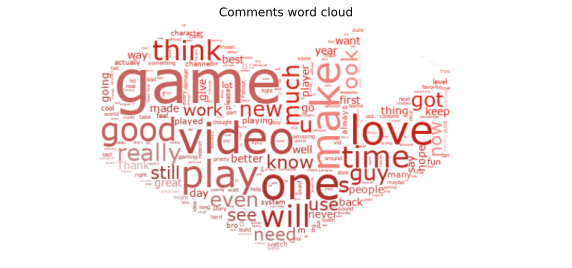

In [115]:
wc = WordCloud(background_color= "white", max_words= 2000, mask= coloring,
               stopwords= stopwords, max_font_size= 80, random_state= 42,
               font_path= 'verdana')

wc.generate(comments)

image_colors = ImageColorGenerator(np.array(coloring))

fig, ax = plt.subplots(1)

ax.imshow(wc.recolor(color_func= image_colors), interpolation="bilinear")
ax.set_axis_off()

plt.title("Comments word cloud")
fig.set_size_inches(10, 10)
plt.show()

Now we will make a word cloud for **video titles data**